<a href="https://colab.research.google.com/github/Diogo364/StepsIntoML/blob/master/Clustering_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparação de Algoritmos Não Supervisionados de Clusterização

Esse trabalho tem como objetivo a comparação do resultados de diferentes algoritmos de clusterização não supervisionados.

Para realizar a comparação entre os algoritmos utilizaremos um dataset do Kaggle, que possui registros de casos de COVID-19 nos diferentes municípios do Brasil e avaliaremos os clusteres de municípios por densidade de casos e mortes utilizando:
- K-Means
- AgglomerativeClustering
- SpectralClustering


---
**Importante:**


- Todos os métodos e classes estão disponíveis na biblioteca `sklearn`.
- Os dados atualizados podem ser obtidos nesse link do [Kaggle](https://www.kaggle.com/unanimad/corona-virus-brazil) e foram disponibilizados e atualizados graças ao trabalho do [Raphael Fontes](https://www.kaggle.com/unanimad)
- Embora os upload dos dados tenham sido feito no timestamp abaixo, realizaremos a análise utilizando apenas os dados de abril:
```
@author: Diogo Telheiro do Nascimento
@publication_date: datetime.datetime(2020, 6, 9, 11, 00) 
```





## Importação de Bibliotecas de Dados
---

- `Pandas:` Manipulação dos dados na forma de DataFrame,
- `Numpy:` Aplicação de fórmulas em Series,
- `Datetime:` Manipulação e transformação de objetos de data,
- `Seaborn/Matplotlib:` Visualização de dados

In [0]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

### Configurações de Plotagem

In [0]:
plt.rcParams['figure.figsize']=12, 12
sns.set_style('darkgrid')

## Funções Personalizadas:
---
No tratamento dos dados utilizaremos as transformações definidas pelas funções abaixo:


In [0]:
def truncate_month(timestamp):
  
  '''
  Padronização e Transformação de Timestamp de objeto Datetime para 
  Date realizando o truncamento do mês.
  e.g:
    timestamp: datetime.datetime(2020, 5, 29, 12, 14, 30, 234543)
    date: datetime.date(2020, 5, 1)
  '''

  return datetime.date(timestamp.year, timestamp.month, 1)

In [0]:
def human_labels_for_cluster(series, human_labels):
  
  '''
  Por padrão o label dos clusteres são números inteiros 
  que variam de de 0 a N-1, sendo N o número de clusteres
  prédefinidos.
  Essa função faz a adaptação dos labels numéricos para 
  categorias pré-determinadas
  '''

  classes_unicas = series.sort_values().unique()
  return series.replace(classes_unicas, human_labels)

In [0]:
def get_names_from_id(target_dataset, names_adaptor, on='code', how='inner'):
  
  '''
  Realiza a conexão interna entre um dataset contendo apenas IDs e outro contendo
  os labels desses IDs.
  '''

  return names_adaptor.merge(target_dataset, on=on, how=how)

## Importando o Dataset
---
No escopo desse trabalho utilizaremos o arquivo `brazil_covid19_cities.csv` do dataset do Kaggle disponibilizado no link na descrição do trabalho.

In [37]:
git_repo = r'https://raw.githubusercontent.com/Diogo364/StepsIntoML/master/data_sets/Brazil_COVID-19/09%3A06%3A2020/brazil_covid19_cities.csv'

try:
  covid_micro = pd.read_csv('brazil_covid19_cities.csv', parse_dates=['date'] ,error_bad_lines=False)
  print('Local File Loaded!')
except:
  covid_micro = pd.read_csv(git_repo, parse_dates=['date'] ,error_bad_lines=False)
  print('Remote File Loaded!')


Remote File Loaded!


In [38]:
covid_micro.head()

,date,state,name,code,cases,deaths
0,2020-03-28,Acre,Rio Branco,120040,25,0
1,2020-03-28,Alagoas,Maceió,270430,13,0
2,2020-03-28,Alagoas,Porto Real do Colégio,270750,1,0
3,2020-03-28,Amapá,Macapá,160030,4,0
4,2020-03-28,Amazonas,Boca do Acre,130070,1,0


## Objetivo

O objetivo dessa análise é realizar a categorização de municípios nos diferentes graus de gravidade, sendo essa uma medida do:
- Número de Casos e 
- Número de Mortes.

Para isso realizaremos os seguites passos:

1. Preparação do dataset com o adaptador de label,
2. Truncamento de datas por mês,
3. Utilizaremos apenas mês de Abril para a análise,
4. Cálculo da média de casos e mortes por mês,
5. Mudança de escala de `casos` para facilitar análise,
6. Retirada dos Outliers.


# Feature Engineering
---

### 1. Criando Adaptador de Labels

In [39]:
names_adaptor = covid_micro[['name', 'code']].drop_duplicates(subset='code')
names_adaptor.head()

,name,code
0,Rio Branco,120040
1,Maceió,270430
2,Porto Real do Colégio,270750
3,Macapá,160030
4,Boca do Acre,130070


### 2. Truncamento de datas

In [0]:
covid_micro['truncated_month'] = covid_micro.date.apply(truncate_month)

In [41]:
covid_micro[['date', 'truncated_month']].head()

,date,truncated_month
0,2020-03-28,2020-03-01
1,2020-03-28,2020-03-01
2,2020-03-28,2020-03-01
3,2020-03-28,2020-03-01
4,2020-03-28,2020-03-01


### 2. Separando os Dados de Abril

In [0]:
abril = datetime.date(2020, 4, 1)
micro_abril = covid_micro[covid_micro.truncated_month == truncate_month(abril)]

### 3. Cálculo Média Mensal de casos e mortes

In [0]:
media_casos_mes = micro_abril.groupby('code').agg('mean')[['deaths', 'cases']].reset_index()

### 4. Mudança de Escala para Casos

In [0]:
media_casos_mes['log_cases'] = np.log(media_casos_mes.cases)

In [45]:
media_casos_mes[['cases', 'log_cases']].head()

,cases,log_cases
0,31.523810,3.450743
1,1.000000,0.000000
2,4.000000,1.386294
3,1.133333,0.125163
4,8.533333,2.143980


### 5. Removendo Outliers

Iremos remover simetricamente 5% dos dados de cada lado para redução do efeito dos outliers.

In [0]:
upper_outliers = media_casos_mes['log_cases'].quantile(0.95)
lower_outliers = media_casos_mes['log_cases'].quantile(0.05)

media_abril_no_outliers = media_casos_mes.loc[(media_casos_mes['log_cases'] <= upper_outliers) &
                                              (media_casos_mes['log_cases'] >= lower_outliers)].sort_values(by='deaths')

In [47]:
media_abril_no_outliers.head()

,code,deaths,cases,log_cases
0,110002,0.0,31.523810,3.450743
1295,350290,0.0,1.285714,0.251314
1292,350270,0.0,1.000000,0.000000
1291,350250,0.0,1.000000,0.000000
1290,350230,0.0,2.000000,0.693147


#### Preparação Para ML

Visando facilitar o uso dos algoritmos de ML iremos deixar nossa base de teste no formato necessário.

In [48]:
base_teste = media_abril_no_outliers[['log_cases', 'deaths']].to_numpy()
base_teste[:5]

array([[3.45074312, 0.        ],
       [0.25131443, 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.69314718, 0.        ]])

---


#OBS:
Para fins didáticos utilizaremos apenas o dataset `media_abril_no_outliers`, visto que a plotagem dos dados contendo os outliers prejudica a visualização da análise.

---

# Machine Learning

## KMeans
---

### **Descrição:**
Esse método de clusterização tenta classificar os dados separando-os em grupos com mesma variância, minimizando inércia, ou soma dos quadrados dentro dos clusteres (*within-cluster sum-of-squares*).

![Fórmula within-cluster sum-of-squares](https://www.hackerearth.com/blog/wp-content/uploads/2017/01/Selection_003-1.png)

---
### **Funcionamento:**

São separados K amostras do dataset de treino e são definidos K centroids a partir disso. Esses centroids são os "centros" de cada cluster.

Após essa etapa os dados são atribuídos aos centróides mais próximos e esse é reposicionado baseado na média da soma das distâncias entre os pontos e os centróides.

Esse processo se repete enquanto a distância entre o ponto inicial dos centróides e o ponto final esteja acima de um determinado limear.

---

### **Limitações:**

Inércia é uma medida de o quanto os dados são internamente coerentes, isso faz com que o modelo apresente algumas limitações: 

1. Inércia assume que os clusteres são convexos e isotrópicos, apresentando, portanto, dificuldades com clusteres alongados ou com muitas irregularidades,
2. Inércia não é uma métrica normalizada e em espaços hiper-dimensionais as distâncias Euclidianas podem ser infladas, portanto, nesses casos é interessante utilizar um algoritmo para redução de dimensões.

Outra grande limitação é relacionada à posição central dos centróides. Essa é definida pelas K amostras separadas aleatoriamente, sendo muito comum o resultado chegar a um ótimo local, ao invés de um global.

---

In [49]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
media_abril_no_outliers['classes'] = kmeans.fit_predict(base_teste)
media_abril_no_outliers.head()

,code,deaths,cases,log_cases,classes
0,110002,0.0,31.523810,3.450743,1
1295,350290,0.0,1.285714,0.251314,0
1292,350270,0.0,1.000000,0.000000,0
1291,350250,0.0,1.000000,0.000000,0
1290,350230,0.0,2.000000,0.693147,3


#### Adaptando Labels

In [50]:
labels = ['Baixo', 'Grave' , 'Muito Grave', 'Médio', ]
media_abril_no_outliers['Gravidade'] = human_labels_for_cluster(media_abril_no_outliers.classes, human_labels=labels)
media_abril_no_outliers[['classes', 'Gravidade']].head()

,classes,Gravidade
0,1,Grave
1295,0,Baixo
1292,0,Baixo
1291,0,Baixo
1290,3,Médio


#### Visualização dos Clusteres

In [0]:
centroids = kmeans.cluster_centers_

Text(0.5, 1.0, 'Clusterização Gravidade usando KMeans')

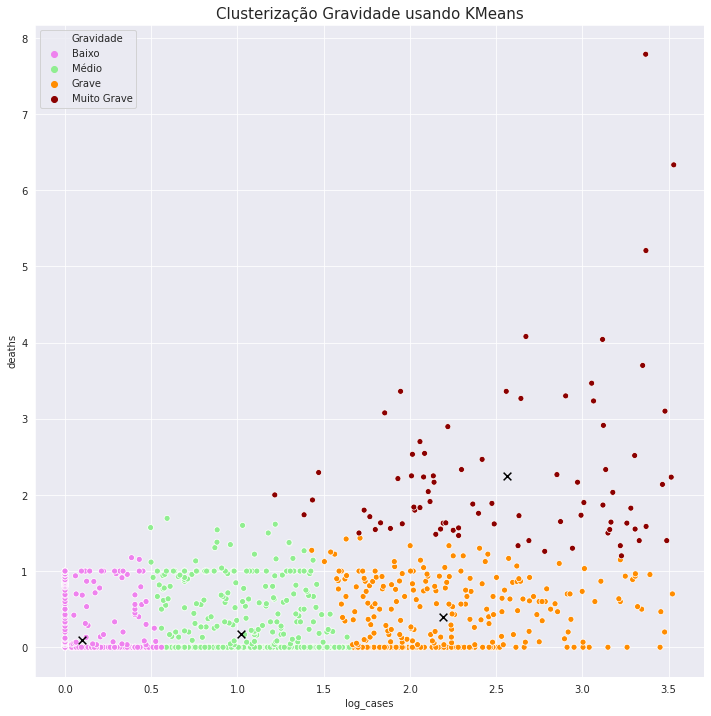

In [52]:
palette = dict(zip(labels, ['violet','darkorange', 'darkred', 'lightgreen']))

ax = sns.scatterplot(data=media_abril_no_outliers , 
                     x='log_cases', 
                     y='deaths', 
                     hue='Gravidade',
                     hue_order=['Baixo','Médio','Grave', 'Muito Grave'], 
                     palette=palette,
                     )

# Visualização de centroid como 'X'
scatter = plt.scatter(x=centroids[:,0], y=centroids[:,1],marker='x', color='black', s=60, linewidths=3,
                      label='Centroid')

plt.title('Clusterização Gravidade usando KMeans', fontsize=15)

**Resetando o Dataset para aplicar próximo modelo**

In [0]:
media_abril_no_outliers.drop(columns=['classes', 'Gravidade'], axis=1, inplace=True)

## AgglomerativeClustering
---

### **Descrição:**

Se trata de um algoritmo da família *Hierarchical clustering*, que cria clusteres aninhados e hierárquicos realizando merges ou divisões sucessivas de clusteres.

---
### **Funcionamento:**

No caso específico do `AgglomerativeClustering`, trata-se de uma abordagem *bottom up*, onde cada observação é um cluster próprio, sendo feitas merges sucessivos.

A forma com que é feita a conexão entre os clusteres é determinada com parâmetro `linkage` que possui 4 possibilidades de escolha:
- `'Ward'`: Minimizar a soma da diferença dos quadrados dentro do cluster para minimizar a variância. Se trata da mesma métrica utilizado no KMeans, porém abordada de uma forma aglomerativa hierárquica.
- `'complete'`: Minimizando a máxima distância entre pares de clusteres.
- `'average'`: Minimizando a média das distâncias entre todas as observações entre pares de clusteres.
- `'single'`: Minimizando a distância entre as observações mais próximas dos pares de clusteres.

---

### **Limitações:**

Esse algoritimo possui um comportamento *'ricos enriquecem mais'* levando a clusteres de tamanhos desiguais. Essa característica deve ser levada em consideração ao se escolher o critério de ligação. Nesse sentido o pior critério é o `'single'` e o melhor o `'ward'` - traz os clusteres mais equilibrados. Porém o `'ward'` só pode utilizar distâncias Euclidianas, portanto para outros tipos de distâncias o `'average'` se torna uma boa alternativa.

Normalmente algoritmos da família de clusteres hierárquicos possuem uma complexidade de tempo e memória altas, sendo considerado custosos nesse aspecto.

O `AgglomerativeClustering` dá a possiblidade de ser utilizado junto de uma matrix de conectividade, o que limita as conexões possíveis entre os clusteres e reduzindo esse problema. A própria documentação não recomenda utilizar números altos de samples sem essa matrix de conectividade.

---

No escopo desse trabalho utilizaremos `linkage='ward'` para compararmos uma abordagem diferente ao mesmo problema utilizando a mesma métrica do KMeans.

In [0]:
from sklearn.cluster import AgglomerativeClustering

In [55]:
spectral = AgglomerativeClustering(4, linkage='ward')
media_abril_no_outliers['classes'] = spectral.fit_predict(base_teste)
media_abril_no_outliers.head()

,code,deaths,cases,log_cases,classes
0,110002,0.0,31.523810,3.450743,3
1295,350290,0.0,1.285714,0.251314,2
1292,350270,0.0,1.000000,0.000000,2
1291,350250,0.0,1.000000,0.000000,2
1290,350230,0.0,2.000000,0.693147,0


#### Adaptando Labels

In [56]:
labels = ['Médio', 'Muito Grave' ,'Baixo', 'Grave']
media_abril_no_outliers['Gravidade'] = human_labels_for_cluster(media_abril_no_outliers.classes, human_labels=labels)
media_abril_no_outliers[['classes', 'Gravidade']].head()

,classes,Gravidade
0,3,Grave
1295,2,Baixo
1292,2,Baixo
1291,2,Baixo
1290,0,Médio


#### Visualização dos Clusteres


Text(0.5, 1.0, 'Clusterização Gravidade usando AgglomerativeClustering')

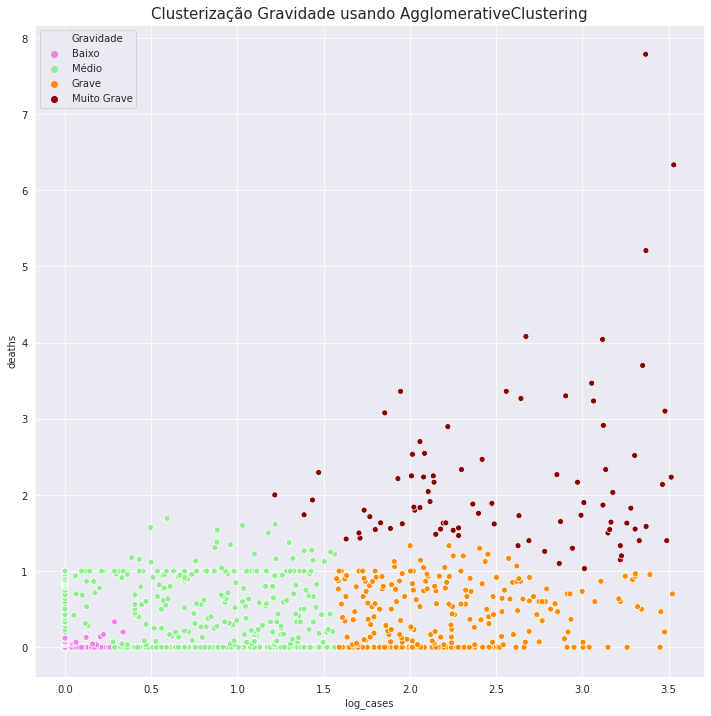

In [57]:
palette = dict(zip(labels, ['lightgreen','darkred', 'violet', 'darkorange']))

ax = sns.scatterplot(data=media_abril_no_outliers, 
                     x='log_cases', 
                     y='deaths', 
                     hue='Gravidade',
                     hue_order=['Baixo','Médio','Grave', 'Muito Grave'], 
                     palette=palette
                     )
plt.title('Clusterização Gravidade usando AgglomerativeClustering', fontsize=15)

**Resetando o Dataset para aplicar próximo modelo**

In [0]:
media_abril_no_outliers.drop(columns=['classes', 'Gravidade'], axis=1, inplace=True)

## Birch
---

### **Descrição:**

Esse algoritmo usa o conceito de *Clustering Feature Tree* para fazer uma representação aglomerada dos dados e definir os clusteres.

---
### **Funcionamento:**

É criada uma Árvore de Caracteristicas de Cluster, que em sua essência é uma maneira de tentar representar os dados de uma forma mais genérica. Cada um dos CF é representado por uma tripla: `(n, LS, SS)`, em que `n` corresponde ao número de dados aglomerados, `LS` é a soma linear das coordenadas e `SS` é a soma linear dos quadrados.

Repare que é uma árvore de CF, portanto um CF pai pode representar vários CF filhos.

Cada CF, além de possuir os valores da tripla, também possui o ponteiro para todos os outros CF acima e abaixo, facilitando o processo de navegação dentro da árvore.

O números máximos de CF aglomerados para nodes internos e nodes folhas são definidos antes de rodar algoritmo e sempre  que esse valor será excedido é um indício para formação de novos nodes e novos ramos da árvore.

Os nodes de CF também utilizam o conceito de hiper-esfera para serem definidos, portanto apenas dados que se localizam dentro do raio de hipere-esfera do CF poderão ser agregados ao CF.

---

### **Limitações:**

- Como os clusteres finais são definidos pelos nodes de CF, o valor n da tripla e a forma com que esses nodes são agregados influenciam na clusterização, podendo trazer resultados diferentes do 'real'.

- Não funciona muito bem em dados com muitas dimensões.

- Possui dificuldades se o valor do raio de hiper-esfera não for representativo dos dados, ou os clusteres não forem convexos.

In [0]:
from sklearn.cluster import Birch

In [60]:
birch = Birch(n_clusters=4)
media_abril_no_outliers['classes'] = birch.fit_predict(base_teste)
media_abril_no_outliers.head()

,code,deaths,cases,log_cases,classes
0,110002,0.0,31.523810,3.450743,2
1295,350290,0.0,1.285714,0.251314,2
1292,350270,0.0,1.000000,0.000000,2
1291,350250,0.0,1.000000,0.000000,2
1290,350230,0.0,2.000000,0.693147,2


#### Adaptando Labels


In [61]:
labels = ['Muito Grave', 'Médio' ,'Baixo', 'Grave']
media_abril_no_outliers['Gravidade'] = human_labels_for_cluster(media_abril_no_outliers.classes, human_labels=labels)
media_abril_no_outliers[['classes', 'Gravidade']].head()

,classes,Gravidade
0,2,Baixo
1295,2,Baixo
1292,2,Baixo
1291,2,Baixo
1290,2,Baixo


#### Visualização dos Clusteres


Text(0.5, 1.0, 'Clusterização Gravidade usando Birch')

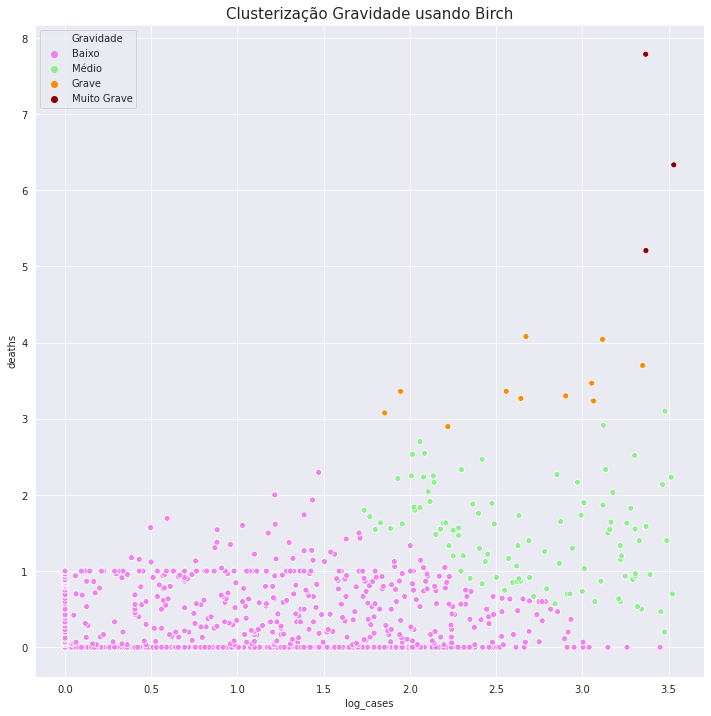

In [62]:
palette = dict(zip(labels, ['darkred','lightgreen', 'violet', 'darkorange']))

ax = sns.scatterplot(data=media_abril_no_outliers, 
                     x='log_cases', 
                     y='deaths', 
                     hue='Gravidade',
                     hue_order=['Baixo','Médio','Grave', 'Muito Grave'], 
                     palette=palette
                     )
plt.title('Clusterização Gravidade usando Birch', fontsize=15)

---
# Conclusão

Todos os três algoritmos separaram os dados nas 4 categorias pré-definidas, porém notam-se diferenças nessas categorizações, alguns dos motivos que explicam essas diferenças são: métricas de aglomeração diferentes, assim como a própria abordagem do algoritmo.


Abaixo irei falar um pouco das constatações que podem ser feitas baseadas em cada um desses fatores.


## Comparando Abordagens diferentes

Os Algoritmos de KMeans e o AgglomerativeClusterings utilizaram a mesma métrica de aglomeração, , porém abordagens diferentes, separando os dados em amostras aleatórias, fazendo ajustes nos centroides e por meio de merges de clusteres no sentido *bottom up*.

Os dois algoritmos trouxeram grupos bem semelhantes quando comparando pontos mais distantes da origem, mostrando que a questão da métrica influencia muito na forma com que os clusteres são organizados.

Em relação aos pontos mais próximos da origem o AgglomerativeClusterings identificou um cluster com uma densidade grande no início, enquanto o KMeans não. Para os critérios específicos do nosso problema - classificação de grau de gravidade - particularmente acredito que o AgglomerativeClusterings trouxe um resultado melhor.

Apesar das grandes semelhanças entre os dois métodos, acredito que para bases de dados pequenas com poucos clusteres o uso do AgglomerativeClusterings é mais recomendável do que o KMeans por remover o fator da aleatoriedade da formação dos clusteres.

## Comparando Métricas diferentes

Em relação aos clusteres formados pelo Algoritmo BIRCH, não acredito que tenha conseguido se adequar bem a esse problema específico, talvez até por uma questão de falta de expertize e questões de hiperparametrização.

Por conta da criação da árvore de CF e de uma certa generização o algoritmo lida muito bem com bases muito grandes, principalmente em relação a custos de memória e tempo.